In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as TR
import pytorch_lightning as pl
from src.config import get_parser
from src.utilities.util import (
    grid_to_list,
    list_to_grid,
    make_faces,
)
from src.utilities.alignment import align
from src.utilities.vertex_normals import VertexNormals
from src.render.mesh_points_renderer import MeshPointsRenderer

torch.set_printoptions(precision=4, sci_mode=False)

def normalize(t):
    return TR.Normalize(t.mean(), t.std())(t)

In [2]:
device = torch.device('cuda')

d = torch.load('./data/npz/ada_wong_resident_evil_256.pth')
vertices = d['vertices'][None].to(device)
normals = d['normals'][None].to(device)

sz = 64
sh = 90
sv = 64
vertices = vertices[:, :, sv:sv+sz, sh:sh+sz]
normals = normals[:, :, sv:sv+sz, sh:sh+sz]
colors = torch.ones_like(vertices)
print(vertices.shape, normals.shape, colors.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


torch.Size([1, 3, 224, 224])


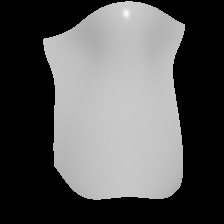

In [3]:
def get_aligned(vrt, nrm):
    p_v, p_n =  align(grid_to_list(vrt), 
                      grid_to_list(nrm),
                      rotate=False)
    return list_to_grid(p_v), list_to_grid(p_n)
    
#224x224
config = get_parser().parse_args(args=[])
config.fast_image_size = 224
config.fast_baseline_size = vertices.size(-1)
config.viewpoint_distance = 0.8

config.fast_image_size = 224
config.fast_baseline_size = vertices.size(-1)
config.viewpoint_distance = 1.0

R = MeshPointsRenderer(config).to(device)
R

vrt_a, _ = get_aligned(vertices, normals)

renders = R(vrt_a, colors, grayscale=False)
rndr_mean, rndr_std =  renders.mean(),  renders.std()
print(renders.shape)
TR.ToPILImage()(renders[0])

In [4]:
vrt_nrm = VertexNormals(config, size=vertices.size(-1)).to(device)

def calculate_normals(t):
    nrm = vrt_nrm.vertex_normals_fast(grid_to_list(t))
    return list_to_grid(nrm)

In [5]:
vertices.requires_grad_(True)

optimizer = torch.optim.Adam([vertices])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [12]:
img_f = '/home/bobi/Desktop/pic2mesh/data/textures/mouth.jpg'
img = Image.open(img_f)
img_size = 224
transform = TR.Compose([
    TR.Resize([img_size, img_size]),
    #Grayscale(),
    TR.ToTensor(),
    #Normalize(mean=(mean), std=(std)),
])
style_img_t = transform(img)
img_mean = img_t.reshape(3, -1).mean(dim=1)
img_std = img_t.reshape(3, -1).std(dim=1)
print(img_mean, img_std)
transform = TR.Compose([
    TR.Resize([img_size, img_size]),    
    TR.ToTensor(),
    TR.Normalize(mean=img_mean, std=img_std),
])
style_img_t = transform(img)[None].to(device)
style_img_t.shape

tensor([0.4027, 0.3958, 0.3829]) tensor([0.1338, 0.1318, 0.1293])


torch.Size([1, 3, 224, 224])

In [13]:
def gram_matrix(t):
    a, b, c, d = t.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = t.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

gram_matrix(style_img_t)

tensor([[0.3333, 0.3333, 0.3332],
        [0.3333, 0.3333, 0.3333],
        [0.3332, 0.3333, 0.3333]], device='cuda:0')

In [10]:
from torchvision import models

#[0,5,10,19,28] are the index of the layers we will be using to calculate the loss as per the paper of NST
#Defining a class that for the model
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        #Here we will use the following layers and make an array of their indices
        # 0: block1_conv1
        # 5: block2_conv1
        # 10: block3_conv1
        # 19: block4_conv1
        # 28: block5_conv1
        self.req_features= ['0','5','10','19','28'] 
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features
    
model =  VGG().to(device).eval() 
model

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [33]:
def all_gram_matrices(features):
    return [gram_matrix(f) for f in features]

def calc_style_loss(gen_features, orig_gms):
    gen_gms = all_gram_matrices(gen_features)    
    return sum([
       torch.mean((G-A)**2)
       for (G, A) in
       zip(gen_gms, orig_gms)
    ])

orig_features =  model(style_img_t)
orig_gms = all_gram_matrices(orig_features)
orig_gms = [f.detach() for f in orig_gms]
len(orig_gms), len(orig_features)

(5, 5)

In [34]:
steps = 10000

for step in range(steps):
    optimizer.zero_grad()
    
    normals =  calculate_normals(vertices.detach())
    vrt_a, nrm_a = get_aligned(vertices, normals)
    renders = R(vrt_a, colors, grayscale=False)
    renders = normalize(renders)
    
    gen_features = model(renders)
    loss = calc_style_loss(gen_features, orig_gms)
        
    loss.backward()
    optimizer.step()    
    if step % 100 == 0:
        print(step, loss.item())
        
    


0 0.0008185110636986792
1 0.0007767367642372847
2 0.0007734113605692983
3 0.0007829282549209893
4 0.0007692724466323853
5 0.0007562473765574396
6 0.0007399111054837704
7 0.0007478021434508264
8 0.000756540335714817
9 0.0007409850368276238
10 0.0007357721915468574
11 0.0007496975013054907
12 0.0007673248765058815
13 0.0007751901866868138
14 0.0007490703137591481
15 0.0007680344861000776
16 0.0007827005465514958
17 0.0007948099519126117
18 0.0008046565926633775
19 0.0008002378162927926
20 0.0007847680826671422
21 0.0007807791116647422
22 0.0007944227545522153
23 0.0007700492860749364
24 0.0007607826846651733
25 0.000758224749006331
26 0.0007697484688833356
27 0.0007684926968067884
28 0.0007660975097678602
29 0.0007863733917474747
30 0.0007906742976047099
31 0.0007734954706393182
32 0.0007853652350604534
33 0.000790174410212785
34 0.0008110130438581109
35 0.0007695410749875009
36 0.0007649415638297796
37 0.0007661343552172184
38 0.0007915101014077663
39 0.0007723484886810184
40 0.00077455

322 0.0009868944762274623
323 0.0009582375641912222
324 0.000945051375310868
325 0.000919317128136754
326 0.000940606405492872
327 0.000962830672506243
328 0.0009114480344578624
329 0.0009100447641685605
330 0.0009419055422767997
331 0.0009044198086485267
332 0.0009039113065227866
333 0.00090842938516289
334 0.0009195751044899225
335 0.0009081207099370658
336 0.0008914504433050752
337 0.0009485736954957247
338 0.0009682652307674289
339 0.0009805546142160892
340 0.000967064406722784
341 0.0009329330059699714
342 0.0009095147252082825
343 0.0009364670258946717
344 0.0009602293721400201
345 0.0009232364827767015
346 0.0009712461614981294
347 0.0009286885033361614
348 0.0009517467115074396
349 0.0009968207450583577
350 0.0010591214522719383
351 0.0010172695619985461
352 0.0010579745285212994
353 0.0010308680357411504
354 0.0009890012443065643
355 0.0009944010525941849
356 0.001020436524413526
357 0.0010593649931252003
358 0.0010593329789116979
359 0.0011402092641219497
360 0.00116337696090

641 0.0007487446418963373
642 0.0007486938266083598
643 0.0007477033650502563
644 0.000729816616512835
645 0.0007372768595814705
646 0.0007600673125125468
647 0.0007713023805990815
648 0.0007663237629458308
649 0.0007660132250748575
650 0.0007628770545125008
651 0.0007743571768514812
652 0.0007719791028648615
653 0.0007674416992813349
654 0.000766341807320714
655 0.0007584242266602814
656 0.0007464265218004584
657 0.0007580016972497106
658 0.0007479690830223262
659 0.0007294465322047472
660 0.0007598894881084561
661 0.0007458607433363795
662 0.0007482482469640672
663 0.000753063359297812
664 0.0007732567610219121
665 0.0007676181849092245
666 0.0007573719485662878
667 0.0007398633169941604
668 0.0007433565915562212
669 0.0007228852482512593
670 0.0007191844051703811
671 0.0007672276115044951
672 0.000742012111004442
673 0.0007529412978328764
674 0.00076696602627635
675 0.0007694013183936477
676 0.0007834298303350806
677 0.0007703459705226123
678 0.0007729994249530137
679 0.000749982602

958 0.0008169827051460743
959 0.0007861849153414369
960 0.0007725048344582319
961 0.0007874452276155353
962 0.0008204214391298592
963 0.0008248410886153579
964 0.0008352924487553537
965 0.0008624808397144079
966 0.0008842230308800936
967 0.0009182250360026956
968 0.0009562202030792832
969 0.0009055837872438133
970 0.0009287599823437631
971 0.0009447719203308225
972 0.0009230476571246982
973 0.0010000260081142187
974 0.0010408590314909816
975 0.001048276317305863
976 0.0011063885176554322
977 0.0011161202564835548
978 0.0011599696008488536
979 0.001091271755285561
980 0.0011191145749762654
981 0.0011251972755417228
982 0.001145430258475244
983 0.001196742756292224
984 0.001139323809184134
985 0.0012039076536893845
986 0.0011746264062821865
987 0.0011227437062188983
988 0.0011999229900538921
989 0.0011622562306001782
990 0.0010572286555543542
991 0.0010935371974483132
992 0.001068148878403008
993 0.0010251947678625584
994 0.0010637901723384857
995 0.0011196023551747203
996 0.001048174221

1266 0.0016021839110180736
1267 0.0017130000051110983
1268 0.0017163774464279413
1269 0.0017413523746654391
1270 0.001813896233215928
1271 0.0017996637616306543
1272 0.001860451651737094
1273 0.0019486886449158192
1274 0.0018127360381186008
1275 0.0019125521648675203
1276 0.002106474479660392
1277 0.0019273407524451613
1278 0.0020127941388636827
1279 0.0020401636138558388
1280 0.0019556425977498293
1281 0.0020160963758826256
1282 0.001955937361344695
1283 0.001818495918996632
1284 0.0017127327155321836
1285 0.0015242566587403417
1286 0.0014296530280262232
1287 0.0013388226507231593
1288 0.0013519057538360357
1289 0.0013528044801205397
1290 0.0014351862482726574
1291 0.001410672557540238
1292 0.0013680689735338092
1293 0.0014084859285503626
1294 0.0013277040561661124
1295 0.001360022579319775
1296 0.001316323410719633
1297 0.0013107637641951442
1298 0.0012700973311439157
1299 0.001226730877533555
1300 0.00117982376832515
1301 0.001186035224236548
1302 0.0011318405158817768
1303 0.001218

1573 0.0009679735521785915
1574 0.0009674665634520352
1575 0.000983928213827312
1576 0.0009948258521035314
1577 0.0009869711939245462
1578 0.0009822506690397859
1579 0.0009700373047962785
1580 0.0009842065628618002
1581 0.0009668234270066023
1582 0.0009512086398899555
1583 0.000948116066865623
1584 0.0009577440214343369
1585 0.0009588452521711588
1586 0.0009402437135577202
1587 0.0009797498350962996
1588 0.0009649292333051562
1589 0.0009971573017537594
1590 0.0009897953132167459
1591 0.0010375733254477382
1592 0.001060845097526908
1593 0.0010667747119441628
1594 0.0010586018906906247
1595 0.001062316121533513
1596 0.0010336001869291067
1597 0.0010293186642229557
1598 0.0010151555761694908
1599 0.0010033074067905545
1600 0.0009997168090194464
1601 0.0010101401712745428
1602 0.0010203419951722026
1603 0.0010368258226662874
1604 0.0010104367975145578
1605 0.001020193798467517
1606 0.0010183536214753985
1607 0.001027034013532102
1608 0.0010157112265005708
1609 0.001004791702143848
1610 0.0

1880 0.0007672673091292381
1881 0.0007739354041405022
1882 0.0007468322291970253
1883 0.0007286195177584887
1884 0.0007317721610888839
1885 0.000754492764826864
1886 0.0007509521674364805
1887 0.0007388296071439981
1888 0.0007476229220628738
1889 0.0007281220750883222
1890 0.0007313945097848773
1891 0.0007174204220063984
1892 0.0007820137543603778
1893 0.0007606340805068612
1894 0.0007309609209187329
1895 0.0007423871429637074
1896 0.000733996625058353
1897 0.0007523233070969582
1898 0.0007456169696524739
1899 0.0007585909334011376
1900 0.0007746672490611672
1901 0.0007595412898808718
1902 0.0007568129803985357
1903 0.0007359085720963776
1904 0.0007411526748910546
1905 0.0007258863188326359
1906 0.0007075743051245809
1907 0.0007244641310535371
1908 0.0007090033032000065
1909 0.0007183561683632433
1910 0.0007095961482264102
1911 0.0006789624458178878
1912 0.0006947226938791573
1913 0.0006873766542412341
1914 0.000669741362798959
1915 0.0006828783662058413
1916 0.0006896462291479111
1917

2185 0.0007107762503437698
2186 0.0007102452800609171
2187 0.0007264950545504689
2188 0.0007369584636762738
2189 0.0007369265658780932
2190 0.0007379231974482536
2191 0.0007262981962412596
2192 0.0007205696310847998
2193 0.0007424335926771164
2194 0.0007573993061669171
2195 0.0007321987650357187
2196 0.000737812602892518
2197 0.0007395875873044133
2198 0.000718893192242831
2199 0.0007114445907063782
2200 0.0007337622228078544
2201 0.0007145144627429545
2202 0.0007081239018589258
2203 0.0007043167133815587
2204 0.0007238767575472593
2205 0.0007135586347430944
2206 0.0007038111798465252
2207 0.0006959598977118731
2208 0.0007220878032967448
2209 0.0007073426386341453
2210 0.0007073291926644742
2211 0.0007115260232239962
2212 0.0007216972298920155
2213 0.0007132788887247443
2214 0.0006923815235495567
2215 0.0006926652858965099
2216 0.0006995487492531538
2217 0.0006944419583305717
2218 0.0006876477273181081
2219 0.0006893614190630615
2220 0.0006861902656964958
2221 0.0006828118930570781
222

KeyboardInterrupt: 

In [36]:
normals =  calculate_normals(vertices.detach())
vrt_a, nrm_a = get_aligned(vertices, normals)
renders = R(vrt_a, colors, grayscale=False)
renders.shape


torch.Size([1, 3, 224, 224])

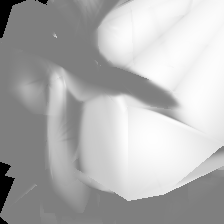

In [37]:
TR.ToPILImage()(renders[0])